In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout

Using TensorFlow backend.


In [4]:
dataset = pd.read_csv('./data/BTC-USD.csv',index_col=['Date'])
dataset.drop(columns = 'Close',inplace=True)
dataset.drop(columns = 'Volume',inplace=True)

In [5]:
dataset = dataset.iloc[:2550,:]

In [6]:
dataset.iloc[-1,:]

High         4303.370117
Low          4006.600098
Open         4007.629883
Adj Close    4081.949951
Name: 2018-12-24, dtype: float64

In [7]:
openp = dataset.loc[:, 'Open'].tolist()
highp = dataset.loc[:, 'High'].tolist()
lowp = dataset.loc[:, 'Low'].tolist()
closep = dataset.loc[:, 'Adj Close'].tolist()

In [8]:
WINDOW = 15
STEP = 15

In [9]:
def to_normalize(dataset):
    Y = []
    z = 0
    for i in range(0, len(dataset),STEP): 
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]

        o = np.array(o) / c[-1]
        h = np.array(h) / c[-1]
        l = np.array(l) / c[-1]
        c = np.array(c) / c[-1]

        x_i = np.column_stack((o, h, l, c))
        Y.append(x_i)
    return np.array(Y)

In [10]:
# split a multivariate dataset into train/test sets
def split_dataset(data):
    division = len(data) - 28*7
    test = data[division-15:]
    train = data[:division+1]
    # restructure into windows of monthly data
    train = np.array(np.split(train, len(train)/15))
    test = np.array(np.split(test, len(test)/7))
    return train, test

In [11]:
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [12]:
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 3])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [13]:
# train the model
def build_model(train, n_input):
    train_x, train_y = processData(train, 15, 7,jump=1)
    # define parameters
    verbose, epochs, batch_size = 0, 100, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [14]:
# train the model
def build_model1(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 150, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [15]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [16]:
# evaluate one or more forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [17]:
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [18]:
train = to_normalize(dataset)
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
data.shape

(2550, 4)

In [106]:
division = len(data) - 28*7

test = data[division-15:]
train = data[:division+1]

In [21]:
x,y = to_supervised(train,15)
x.shape
y.shape

(2528, 7)

In [111]:
train.shape

(157, 15, 4)

In [110]:
train = np.array(np.split(train, len(train)/15))
#test = np.array(np.split(test, len(test)/7))

ValueError: array split does not result in an equal division

In [102]:
t,s = processData(train, 15, 7,jump=1)
t.shape

(2383, 15, 4)

In [90]:
scores,scores1 = evaluate_model(train,test,15)

ValueError: Error when checking target: expected dense_24 to have 2 dimensions, but got array with shape (2334, 7, 4)

In [20]:
dataset.iloc[-1,:]

High         4303.370117
Low          4006.600098
Open         4007.629883
Adj Close    4081.949951
Name: 2018-12-24, dtype: float64

In [109]:
dataset.shape

(2550, 4)

In [110]:
train_ori,test_ori = split_dataset(dataset.values)

(2505, 4)
(45, 4)


In [22]:
model = build_model(train,15)

ValueError: Error when checking input: expected conv1d_1_input to have 3 dimensions, but got array with shape (149, 15, 15, 4)

In [62]:
train
history = [x for x in train]

In [63]:
next_7_days_price = forecast(model,history,15)
# b = test_ori1[:7,3]
# b

In [64]:
a = (next_7_days_price*4081.949).tolist()
a

[3744.0849609375,
 3757.76416015625,
 3771.2685546875,
 3781.94921875,
 3812.94140625,
 3845.801025390625,
 3856.70654296875]

In [69]:
import matplotlib.pyplot as plt

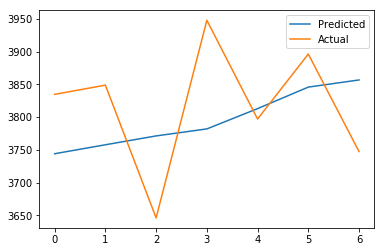

In [65]:
plt.plot(a,label='Predicted')
plt.plot(b,label='Actual')
plt.legend(loc=1)
plt.show()

In [71]:
b = dataset.iloc[2550:2557,3].values.tolist()

In [25]:
b=[3834.72998046875,
 3848.780029296875,
 3646.090087890625,
 3947.860107421875,
 3797.06005859375,
 3896.2099609375,
 3747.389892578125]

In [46]:
dataset.shape

(2558, 4)